# TradingMotion Portfolios

Herramienta para analizar portfolios de estrategias TradingMotion SDK

Esta herramienta ha sido creada para ayudar a los participantes del concurso Robotrader (categoría TradingMotion)

In [1]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

#Imports varios
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import sys, os
import pandas as pd
import datetime
import numpy as np

import seaborn as sns
sns.set_style("whitegrid")


In [2]:
pylab.rcParams['figure.figsize'] = 16, 6

## Definición del portfolio

El directorio _reports/_ debe contener los informes excel (exportados de la herramienta TradingMotion SDK Toolkit) de todos los sistemas que queramos incluir en el portfolio. 

Los definiremos en el siguiente format json:

```json
portfolio = {
    <ruta_fichero_informe_excel> : <multiplicador>
}
```

El parámetro **multiplicador** sirve para aumentar la exposición a la estrategia. Una estrategia con multiplicador 10, será incluida 10 veces en el portfolio

In [3]:
portfolio = {
    "reports/TrackingTendenceStrategy Performance - GC.xlsx": 100,
    "reports/TrackingTendenceStrategy Performance - ES.xlsx": 50,
}

## Construcción del portfolio combinado

In [4]:
# Cargamos los informes excel

df_sessionlogs = {}

for informe_path in portfolio:
    multiplicador = portfolio[informe_path]
    df = pd.read_excel(informe_path, 2, header=0, skiprows=2)
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
    df = df.set_index("Date").sort_index()[["Net P&L (USD)"]]
    df["Net P&L (USD)"] = df["Net P&L (USD)"] * multiplicador
    df_sessionlogs[informe_path] = df

In [5]:
# Los combinamos en un solo pandas dataframe para hacer el portfolio

df_portfolio = None

for informe_path in df_sessionlogs:
    if df_portfolio is None:
        df_portfolio = df_sessionlogs[informe_path]
        df_portfolio.columns = [informe_path]
    else:
        df_portfolio = df_portfolio.join(df_sessionlogs[informe_path].rename(columns={
            "Net P&L (USD)":informe_path
        })).fillna(0)
        
# Creamos la columna PORTFOLIO con el P&L combinado
df_portfolio["PORTFOLIO"] = df_portfolio.sum(axis=1)

In [6]:
# Visualizamos como ha quedado el dataframe combinado
df_portfolio.sample(5)

,reports/TrackingTendenceStrategy Performance - GC.xlsx,reports/TrackingTendenceStrategy Performance - ES.xlsx,PORTFOLIO
Date,,,
2017-01-10,-36000.0,-1875.0,-37875.0
2016-12-19,29000.0,-7500.0,21500.0
2016-06-09,70000.0,-13750.0,56250.0
2015-06-23,93000.0,6875.0,99875.0
2015-08-27,20000.0,123125.0,143125.0


## Análisis del portfolio

El tamaño del portfolio (o Capital Sugerido en la terminología de TradingMotion), se puede calcular con la siguiente aproximación:

```
capital_sugerido = MAX( 3.6*peor_drawdown , 10*peor_sesion)
```

En otras palabras, tomaremos como capital sugerido el valor más grande entre 3.6 veces el peor drawdown y 10 veces la peor sesión

In [7]:
# Cálculo de peor sesión
peor_sesion = df_portfolio["PORTFOLIO"].min()

# Cálculo de peor drawdown
cumulative = df_portfolio["PORTFOLIO"].cumsum().values
max_return = np.fmax.accumulate(cumulative)

peor_drawdown = np.nanmin(cumulative - max_return)

# Cálculo de capital sugerido
capital_sugerido = round(min(3.6*peor_drawdown,10*peor_sesion),0)

# Visualizamos el capital sugerido
df_estadisticas = pd.DataFrame.from_dict({
    "peor sesion": peor_sesion,
    "peor drawdown": peor_drawdown,
    "CAPITAL SUGERIDO": abs(capital_sugerido)
},"index")

df_estadisticas.columns = ["PORTFOLIO"]

df_estadisticas

,PORTFOLIO
peor sesion,-850625.0
peor drawdown,-1841500.0
CAPITAL SUGERIDO,8506250.0


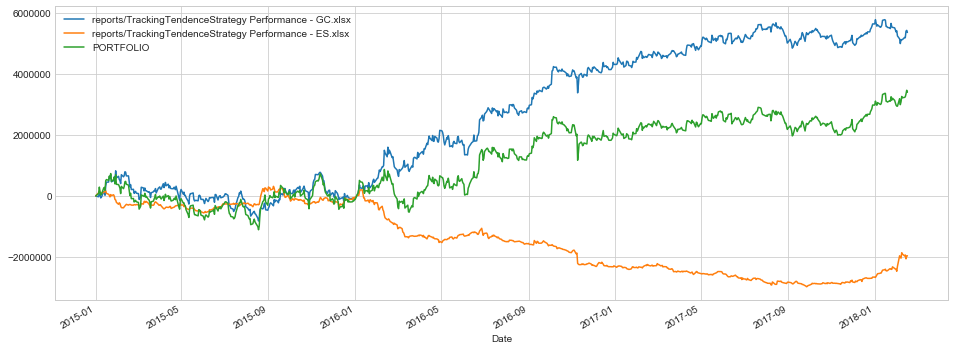

In [8]:
# Graficamos el portfolio
df_portfolio.cumsum().plot();